# Training And Tuning Hyperparametres

## Import Libraries

In [1]:
import os

In [2]:
os.environ["OPENBLAS_NUM_THREADS"] = "1"  # For implicit ALS

In [3]:
import warnings

warnings.filterwarnings("ignore")

In [4]:
import itertools
import timeit
import typing as tp
from pathlib import Path

import dill
import matplotlib.pyplot as plt
import numpy as np
import optuna
import pandas as pd
import seaborn as sns
from implicit.als import AlternatingLeastSquares
from implicit.bpr import BayesianPersonalizedRanking
from lightfm import LightFM
from rectools import Columns
from rectools.dataset import Dataset
from rectools.metrics import MAP, calc_metrics  # , Precision, Recall,
from rectools.models import ImplicitALSWrapperModel, LightFMWrapperModel
from scipy import sparse
from tqdm.notebook import tqdm

In [5]:
np.random.seed(23)

In [6]:
DATA_PATH = Path("kion_train")

## Loading Data

In [56]:
%%time
users = pd.read_csv(DATA_PATH / "users.csv")
items = pd.read_csv(DATA_PATH / "items.csv")
interactions = pd.read_csv(DATA_PATH / "interactions.csv")

CPU times: user 3.76 s, sys: 260 ms, total: 4.02 s
Wall time: 4.08 s


## Preprocessing

### Interactions dataframe

In [57]:
def headtail(df: pd.DataFrame):
    return pd.concat([df.head(), df.tail()])

In [58]:
Columns.Datetime = "last_watch_dt"

In [59]:
interactions.drop(
    interactions[interactions[Columns.Datetime].str.len() != 10].index, inplace=True
)

In [60]:
interactions[Columns.Datetime] = pd.to_datetime(
    interactions[Columns.Datetime], format="%Y-%m-%d"
)

In [61]:
max_date = interactions[Columns.Datetime].max()

Используем долю просмотренного как веса + определим правило для конвертации в пятибальную шкалу

In [62]:
def convert_to_weight(col):
    if col < 10:
        return 1
    elif col < 30:
        return 2
    elif col < 60:
        return 3
    elif col < 85:
        return 4
    return 5

In [63]:
interactions[Columns.Weight] = interactions["watched_pct"].apply(
    lambda x: convert_to_weight(x)
)

In [64]:
interactions

,user_id,item_id,last_watch_dt,total_dur,watched_pct,weight
0,176549,9506,2021-05-11,4250,72.0,4
1,699317,1659,2021-05-29,8317,100.0,5
2,656683,7107,2021-05-09,10,0.0,1
3,864613,7638,2021-07-05,14483,100.0,5
4,964868,9506,2021-04-30,6725,100.0,5
...,...,...,...,...,...,...
5476246,648596,12225,2021-08-13,76,0.0,1
5476247,546862,9673,2021-04-13,2308,49.0,3
5476248,697262,15297,2021-08-20,18307,63.0,4
5476249,384202,16197,2021-04-19,6203,100.0,5


## Features Preparing and Analyzing

### User features

In [65]:
users.isnull().sum()

user_id         0
age         14095
income      14776
sex         13831
kids_flg        0
dtype: int64

In [66]:
users.fillna("Unknown", inplace=True)

In [67]:
users.nunique()

user_id     840197
age              7
income           7
sex              3
kids_flg         2
dtype: int64

In [68]:
headtail(users)

,user_id,age,income,sex,kids_flg
0,973171,age_25_34,income_60_90,М,1
1,962099,age_18_24,income_20_40,М,0
2,1047345,age_45_54,income_40_60,Ж,0
3,721985,age_45_54,income_20_40,Ж,0
4,704055,age_35_44,income_60_90,Ж,0
840192,339025,age_65_inf,income_0_20,Ж,0
840193,983617,age_18_24,income_20_40,Ж,1
840194,251008,Unknown,Unknown,Unknown,0
840195,590706,Unknown,Unknown,Ж,0
840196,166555,age_65_inf,income_20_40,Ж,0


In [69]:
users = users.astype({"kids_flg": bool})

#### Generate user features dataset

In [70]:
user_features_frames = []
for feature in ["sex", "age", "income", "kids_flg"]:
    feature_frame = users.reindex(columns=[Columns.User, feature])
    feature_frame.columns = ["id", "value"]
    feature_frame["feature"] = feature
    user_features_frames.append(feature_frame)
user_features = pd.concat(user_features_frames)
user_features.head()

,id,value,feature
0,973171,М,sex
1,962099,М,sex
2,1047345,Ж,sex
3,721985,Ж,sex
4,704055,Ж,sex


In [71]:
user_features.query(f"id == 973171")

,id,value,feature
0,973171,М,sex
0,973171,age_25_34,age
0,973171,income_60_90,income
0,973171,True,kids_flg


### Item features

In [72]:
# Full data
items = pd.read_csv(DATA_PATH / "items.csv")

In [73]:
headtail(items)

,item_id,content_type,title,title_orig,release_year,genres,countries,for_kids,age_rating,studios,directors,actors,description,keywords
0,10711,film,Поговори с ней,Hable con ella,2002.0,"драмы, зарубежные, детективы, мелодрамы",Испания,NaN,16.0,NaN,Педро Альмодовар,"Адольфо Фернандес, Ана Фернандес, Дарио Гранди...",Мелодрама легендарного Педро Альмодовара «Пого...,"Поговори, ней, 2002, Испания, друзья, любовь, ..."
1,2508,film,Голые перцы,Search Party,2014.0,"зарубежные, приключения, комедии",США,NaN,16.0,NaN,Скот Армстронг,"Адам Палли, Брайан Хаски, Дж.Б. Смув, Джейсон ...",Уморительная современная комедия на популярную...,"Голые, перцы, 2014, США, друзья, свадьбы, прео..."
2,10716,film,Тактическая сила,Tactical Force,2011.0,"криминал, зарубежные, триллеры, боевики, комедии",Канада,NaN,16.0,NaN,Адам П. Калтраро,"Адриан Холмс, Даррен Шалави, Джерри Вассерман,...",Профессиональный рестлер Стив Остин («Все или ...,"Тактическая, сила, 2011, Канада, бандиты, ганг..."
3,7868,film,45 лет,45 Years,2015.0,"драмы, зарубежные, мелодрамы",Великобритания,NaN,16.0,NaN,Эндрю Хэй,"Александра Риддлстон-Барретт, Джеральдин Джейм...","Шарлотта Рэмплинг, Том Кортни, Джеральдин Джей...","45, лет, 2015, Великобритания, брак, жизнь, лю..."
4,16268,film,Все решает мгновение,NaN,1978.0,"драмы, спорт, советские, мелодрамы",СССР,NaN,12.0,Ленфильм,Виктор Садовский,"Александр Абдулов, Александр Демьяненко, Алекс...",Расчетливая чаровница из советского кинохита «...,"Все, решает, мгновение, 1978, СССР, сильные, ж..."
15958,6443,series,Полярный круг,Arctic Circle,2018.0,"драмы, триллеры, криминал","Финляндия, Германия",NaN,16.0,NaN,Ханну Салонен,"Иина Куустонен, Максимилиан Брюкнер, Пихла Вии...","Во время погони за браконьерами по лесу, сотру...","убийство, вирус, расследование преступления, н..."
15959,2367,series,Надежда,NaN,2020.0,"драмы, боевики",Россия,0.0,18.0,NaN,Елена Хазанова,"Виктория Исакова, Александр Кузьмин, Алексей М...",Оригинальный киносериал от создателей «Бывших»...,"Надежда, 2020, Россия"
15960,10632,series,Сговор,Hassel,2017.0,"драмы, триллеры, криминал",Россия,0.0,18.0,NaN,"Эшреф Рейбрук, Амир Камдин, Эрик Эгер","Ола Рапас, Алиетт Офейм, Уильма Лиден, Шанти Р...",Криминальная драма по мотивам романов о шведск...,"Сговор, 2017, Россия"
15961,4538,series,Среди камней,Darklands,2019.0,"драмы, спорт, криминал",Россия,0.0,18.0,NaN,"Марк О’Коннор, Конор МакМахон","Дэйн Уайт О’Хара, Томас Кэйн-Бирн, Джудит Родд...",Семнадцатилетний Дэмиен мечтает вырваться за п...,"Среди, камней, 2019, Россия"
15962,3206,series,Гоша,NaN,2019.0,комедии,Россия,0.0,16.0,NaN,Михаил Миронов,"Мкртыч Арзуманян, Виктория Рунцова","Добродушный Гоша не может выйти из дома, чтобы...","Гоша, 2019, Россия"


In [25]:
items = items.loc[items[Columns.Item].isin(train[Columns.Item])].copy()

NameError: name 'train' is not defined

In [34]:
items.head()

,item_id,content_type,title,title_orig,release_year,genres,countries,for_kids,age_rating,studios,directors,actors,description,keywords
0,10711,film,Поговори с ней,Hable con ella,2002.0,"драмы, зарубежные, детективы, мелодрамы",Испания,False,16,NaN,Педро Альмодовар,"Адольфо Фернандес, Ана Фернандес, Дарио Гранди...",Мелодрама легендарного Педро Альмодовара «Пого...,"Поговори, ней, 2002, Испания, друзья, любовь, ..."
1,2508,film,Голые перцы,Search Party,2014.0,"зарубежные, приключения, комедии",США,False,16,NaN,Скот Армстронг,"Адам Палли, Брайан Хаски, Дж.Б. Смув, Джейсон ...",Уморительная современная комедия на популярную...,"Голые, перцы, 2014, США, друзья, свадьбы, прео..."
2,10716,film,Тактическая сила,Tactical Force,2011.0,"криминал, зарубежные, триллеры, боевики, комедии",Канада,False,16,NaN,Адам П. Калтраро,"Адриан Холмс, Даррен Шалави, Джерри Вассерман,...",Профессиональный рестлер Стив Остин («Все или ...,"Тактическая, сила, 2011, Канада, бандиты, ганг..."
3,7868,film,45 лет,45 Years,2015.0,"драмы, зарубежные, мелодрамы",Великобритания,False,16,NaN,Эндрю Хэй,"Александра Риддлстон-Барретт, Джеральдин Джейм...","Шарлотта Рэмплинг, Том Кортни, Джеральдин Джей...","45, лет, 2015, Великобритания, брак, жизнь, лю..."
4,16268,film,Все решает мгновение,NaN,1978.0,"драмы, спорт, советские, мелодрамы",СССР,True,12,Ленфильм,Виктор Садовский,"Александр Абдулов, Александр Демьяненко, Алекс...",Расчетливая чаровница из советского кинохита «...,"Все, решает, мгновение, 1978, СССР, сильные, ж..."


#### Genre

In [74]:
items["genres"].isna().sum()

0

In [75]:
# Explode genres to flatten table
items["genre"] = (
    items["genres"].str.lower().str.replace(", ", ",", regex=False).str.split(",")
)
genre_feature = items[["item_id", "genre"]].explode("genre")
genre_feature.columns = ["id", "value"]
genre_feature["feature"] = "genre"
genre_feature.head()

,id,value,feature
0,10711,драмы,genre
0,10711,зарубежные,genre
0,10711,детективы,genre
0,10711,мелодрамы,genre
1,2508,зарубежные,genre


#### Content

Признак уже готов

In [76]:
items["content_type"].isna().sum()

0

In [77]:
items["content_type"].unique()

array(['film', 'series'], dtype=object)

#### Release year

In [78]:
items[items["release_year"].isna()]

,item_id,content_type,title,title_orig,release_year,genres,countries,for_kids,age_rating,studios,directors,actors,description,keywords,genre
89,10950,series,Начни дома,NaN,NaN,фитнес,Россия,NaN,6.0,NaN,NaN,NaN,Приведи себя в хорошую форму дома с минимальны...,"Начни, дома, Россия, спорт-фитнес, спорт-трене...",[фитнес]
294,3901,series,Красота лица,NaN,NaN,фитнес,Россия,NaN,0.0,NaN,NaN,NaN,"Motify научит вас простым, но очень эффективны...","Красота, лица, 2020, Россия, спорт-фитнес, спо...",[фитнес]
374,10656,series,Медитации для жизни,NaN,NaN,фитнес,NaN,NaN,6.0,NaN,NaN,NaN,"В этой программе собраны 3 базовых урока, на к...","Медитации, для, жизни, спорт-фитнес, спорт-тре...",[фитнес]
375,11526,series,Психология питания,NaN,NaN,"фитнес, спорт",NaN,NaN,6.0,NaN,NaN,NaN,В программе от Motify ты узнаешь о психологиче...,"Психология, питания","[фитнес, спорт]"
572,11532,series,Йога старт,NaN,NaN,фитнес,Россия,NaN,6.0,NaN,NaN,NaN,Программа от Motify подойдет для любого уровня...,"Йога, 2020, Россия, спорт-фитнес, спорт-тренер...",[фитнес]
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
15391,12643,series,Идеальная осанка и мышечный рельеф,NaN,NaN,фитнес,Россия,NaN,6.0,NaN,NaN,NaN,Программа от Motify представляет собой функцио...,"Идеальная, осанка, мышечный, рельеф, Россия, с...",[фитнес]
15609,15173,film,Порт - Сересо Осака,NaN,NaN,футбол,Россия,NaN,0.0,NaN,NaN,NaN,Лига чемпионов AFC - это главный клубный футбо...,"Порт, -, Сересо, Осака, Россия, спорт-фитнес, ...",[футбол]
15826,8206,series,Рацион на 1478 ккал,NaN,NaN,фитнес,Россия,NaN,6.0,NaN,NaN,NaN,Готовый рацион на день от Motify. Состоит из п...,"Рацион, 1478, ккал, Россия, спорт-фитнес, спор...",[фитнес]
15827,13968,series,Рацион на 2534 ккал,NaN,NaN,фитнес,Россия,NaN,6.0,NaN,NaN,NaN,Готовые рецепты с подробной инструкцией. 4 при...,"Рацион, 2534, ккал, Россия, спорт-фитнес, спор...",[фитнес]


Небольшое число айтемов с отсутствующей датой выхода. Судя по жанрам (в основном фитнес) и названиям, это с большой вероятностью вещи, вышедшие недавно, поэтому заполним все `null` значениями последним годом

In [79]:
items["release_year"].fillna(int(items["release_year"].max()), inplace=True)

Преобразуем

In [80]:
items = items.astype({"release_year": int})

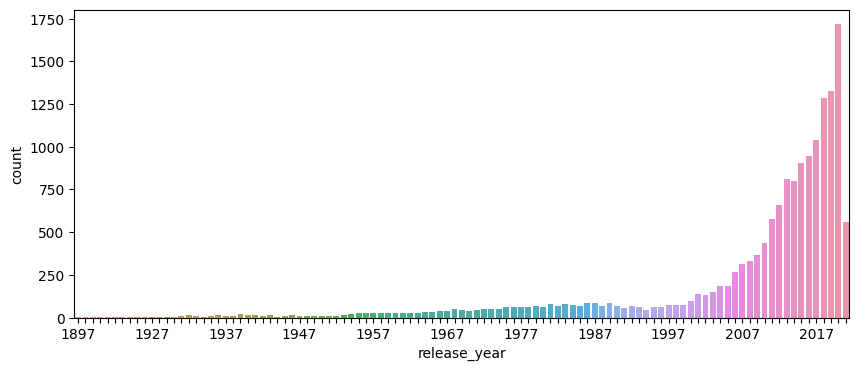

In [81]:
plt.figure(figsize=(10, 4))
plot = sns.countplot(x=items["release_year"])
# plt.tight_layout()

for ind, label in enumerate(plot.get_xticklabels()):
    if ind % 10 == 0:  # every 10th label is kept
        label.set_visible(True)
    else:
        label.set_visible(False)

Видим, что количество фильмов, вышедших с 1897 по ~1977, гораздо меньше, чем вышедших позже, поэтому логичнее отрезок последних лет разбить на более мелкие равные интервалы, а фильмы прошлого поместить в один более длительный

In [82]:
year_from = 1977
step = 5
bins = [year for year in range(year_from, items["release_year"].max() + step, step)]

In [83]:
bins

[1977, 1982, 1987, 1992, 1997, 2002, 2007, 2012, 2017, 2022]

Делаем интервалы (строгое вхождение)

In [84]:
bins_bias = [item + 1 for item in bins]

In [85]:
pairs_strict = list(zip(bins_bias, bins[1:]))
pairs_strict

[(1978, 1982),
 (1983, 1987),
 (1988, 1992),
 (1993, 1997),
 (1998, 2002),
 (2003, 2007),
 (2008, 2012),
 (2013, 2017),
 (2018, 2022)]

In [86]:
# Add the most first release year
bins = [items["release_year"].min()] + bins
# Add interval for it
pairs_strict = [(items["release_year"].min(), bins[1])] + pairs_strict
# Generate feature values
labels = [f"year_{item[0]}_{item[1]}" for item in pairs_strict]

In [87]:
labels

['year_1897_1977',
 'year_1978_1982',
 'year_1983_1987',
 'year_1988_1992',
 'year_1993_1997',
 'year_1998_2002',
 'year_2003_2007',
 'year_2008_2012',
 'year_2013_2017',
 'year_2018_2022']

In [88]:
year_bins = pd.cut(items["release_year"], bins=bins, labels=labels, include_lowest=True)

In [89]:
items["release_year"] = year_bins.astype(str)

In [90]:
items["release_year"].unique()

array(['year_1998_2002', 'year_2013_2017', 'year_2008_2012',
       'year_1978_1982', 'year_1897_1977', 'year_2018_2022',
       'year_1983_1987', 'year_2003_2007', 'year_1988_1992',
       'year_1993_1997'], dtype=object)

#### Age rating

In [91]:
items["age_rating"].unique()

array([16., 12.,  6., 18.,  0., 21., nan])

In [92]:
items[items["age_rating"].isna()]

,item_id,content_type,title,title_orig,release_year,genres,countries,for_kids,age_rating,studios,directors,actors,description,keywords,genre
8297,6316,series,Машины-помощники,NaN,year_2013_2017,"русские, для детей, сериалы, хочу всё знать, р...",Россия,NaN,NaN,NaN,NaN,NaN,Маленькие мальчики всего мира любят играть в м...,"Машины-помощники, 2017, Россия, работа, преодо...","[русские, для детей, сериалы, хочу всё знать, ..."
12352,14409,series,БиБаБу,NaN,year_2013_2017,"русские, сериалы, для детей, хочу всё знать, р...",Россия,NaN,NaN,NaN,NaN,NaN,В сказочное подводное царство приглашают мален...,"друзья, магия и волшебство, рыбы, моря и океан...","[русские, сериалы, для детей, хочу всё знать, ..."


Вручную доопределим рейтинг этих мультфильмов

In [93]:
items["age_rating"].fillna(0, inplace=True)

In [94]:
items = items.astype({"age_rating": int})

#### For kids

Если возраст 12+, тогда взрослый контент, иначе - детский 

In [95]:
items["for_kids"].isna().sum()

15397

In [96]:
items.loc[items["age_rating"] > 12, "for_kids"] = 0
items.loc[items["age_rating"] <= 12, "for_kids"] = 1

In [97]:
items = items.astype({"for_kids": bool})

#### Generate item features dataset

In [98]:
item_features_frames = []
for feature in ["content_type", "release_year", "age_rating", "for_kids"]:
    feature_frame = items.reindex(columns=[Columns.Item, feature])
    feature_frame.columns = ["id", "value"]
    feature_frame["feature"] = feature
    item_features_frames.append(feature_frame)
item_features_frames.append(genre_feature)
item_features = pd.concat(item_features_frames)
headtail(item_features)

,id,value,feature
0,10711,film,content_type
1,2508,film,content_type
2,10716,film,content_type
3,7868,film,content_type
4,16268,film,content_type
15960,10632,криминал,genre
15961,4538,драмы,genre
15961,4538,спорт,genre
15961,4538,криминал,genre
15962,3206,комедии,genre


In [99]:
item_features.query(f"id == 10711")

,id,value,feature
0,10711,film,content_type
0,10711,year_1998_2002,release_year
0,10711,16,age_rating
0,10711,False,for_kids
0,10711,драмы,genre
0,10711,зарубежные,genre
0,10711,детективы,genre
0,10711,мелодрамы,genre


### Validation scheme

### Feature preparing

## MAP@10 on the best model using TimeSplit() validation

### Validation scheme

Разбиение на фолды по временным интервалам. Схема
- `[..., w4, w3, w2] | [w1]`
- `[..., w4, w3] | [w2]`
- `[..., w4] | [w3]`
- `...`
- `[..., w_(N+1)] | [wN]`

In [104]:
n_folds = 3
unit = "W"
n_units = 1
last_date = interactions[Columns.Datetime].max()

start_date = last_date - pd.Timedelta(n_folds * n_units, unit=unit)
periods = n_folds + 1
freq = f"{n_units}{unit}"
print(
    f"""
    start_date: {start_date}
    last_date: {last_date}
    periods: {periods}
    freq: {freq}
"""
)

date_range = pd.date_range(
    start=start_date, periods=periods, freq=freq, tz=last_date.tz
)
date_range


    start_date: 2021-08-01 00:00:00
    last_date: 2021-08-22 00:00:00
    periods: 4
    freq: 1W



DatetimeIndex(['2021-08-01', '2021-08-08', '2021-08-15', '2021-08-22'], dtype='datetime64[ns]', freq='W-SUN')

In [105]:
from itertools import tee


def pairwise(iterable):
    # pairwise('ABCDEFG') --> AB BC CD DE EF FG
    a, b = tee(iterable)
    next(b, None)
    return zip(a, b)

In [109]:
class TimeSplit:
    def __init__(
        self,
        date_range,
        full=False,
        filter_cold_users=True,
        date_column=Columns.Datetime,
    ):
        self.date_range = date_range
        self.filter_cold_users = filter_cold_users
        self.date_column = date_column
        self.full = full

    def split(self, df):
        for i, (start, end) in enumerate(pairwise(self.date_range)):

            if not self.full:
                # Generate Bernoulli value for each row while building a mask
                # as optimization step - take less data
                train_mask = (interactions[self.date_column] <= start) & (
                    np.random.binomial(1, p=0.05, size=len(interactions))
                )
                test_mask = (
                    (interactions[self.date_column] > start)
                    & (interactions[self.date_column] <= end)
                    & (np.random.binomial(1, p=0.05, size=len(interactions)))
                )
            else:
                train_mask = interactions[self.date_column] <= start
                test_mask = (interactions[self.date_column] > start) & (
                    interactions[self.date_column] <= end
                )

            if self.filter_cold_users:
                train_users = df.loc[train_mask, Columns.User].unique()
                test_users = df.loc[test_mask, Columns.User].unique()
                cold_users = np.setdiff1d(test_users, train_users)
                test_mask &= ~df.loc[test_mask, Columns.User].isin(cold_users)

            yield train_mask, test_mask

### Preparing features

In [113]:
%%time
users = pd.read_csv(DATA_PATH / "users.csv")
items = pd.read_csv(DATA_PATH / "items.csv")

CPU times: user 1.11 s, sys: 60.1 ms, total: 1.17 s
Wall time: 1.21 s


Генерируем фичи на основании изменяющихся (зависят от датасета взаимодействий `interactions`) датасетов `users` и `items`. Логика процессинга фичей была представлена выше, обернем для удобства в функцию 

In [114]:
def get_features(users: pd.DataFrame, items: pd.DataFrame, for_hot=True):

    # Generate user/item features for hot users, i.e. syncronise with interactions
    if for_hot:
        users = users.loc[users[Columns.User].isin(interactions[Columns.User])].copy()
    items = items.loc[items[Columns.Item].isin(interactions[Columns.Item])].copy()

    # Deal with user features

    users.fillna("Unknown", inplace=True)
    users = users.astype({"kids_flg": bool})

    user_features_frames = []
    for feature in ["sex", "age", "income", "kids_flg"]:
        feature_frame = users.reindex(columns=[Columns.User, feature])
        feature_frame.columns = ["id", "value"]
        feature_frame["feature"] = feature
        user_features_frames.append(feature_frame)

    user_features = pd.concat(user_features_frames)

    # Deal with item features
    # Genre

    items["genre"] = (
        items["genres"].str.lower().str.replace(", ", ",", regex=False).str.split(",")
    )
    genre_feature = items[["item_id", "genre"]].explode("genre")
    genre_feature.columns = ["id", "value"]
    genre_feature["feature"] = "genre"
    genre_feature.head()

    # Release year

    items["release_year"].fillna(int(items["release_year"].max()), inplace=True)
    items = items.astype({"release_year": int})

    year_from = 1977
    step = 5
    bins = [year for year in range(year_from, items["release_year"].max() + step, step)]

    bins_bias = [item + 1 for item in bins]
    pairs_strict = list(zip(bins_bias, bins[1:]))
    # Add the most first release year
    bins = [items["release_year"].min()] + bins
    # Add interval for it
    pairs_strict = [(items["release_year"].min(), bins[1])] + pairs_strict
    # Generate feature values
    labels = [f"year_{item[0]}_{item[1]}" for item in pairs_strict]

    year_bins = pd.cut(
        items["release_year"], bins=bins, labels=labels, include_lowest=True
    )

    items["release_year"] = year_bins.astype(str)

    # Age rating

    items["age_rating"].fillna(0, inplace=True)
    items = items.astype({"age_rating": int})

    # For kids

    items.loc[items["age_rating"] > 12, "for_kids"] = 0
    items.loc[items["age_rating"] <= 12, "for_kids"] = 1
    items = items.astype({"for_kids": bool})

    item_features_frames = []
    for feature in ["content_type", "release_year", "age_rating", "for_kids"]:
        feature_frame = items.reindex(columns=[Columns.Item, feature])
        feature_frame.columns = ["id", "value"]
        feature_frame["feature"] = feature
        item_features_frames.append(feature_frame)
    item_features_frames.append(genre_feature)
    item_features = pd.concat(item_features_frames)
    headtail(item_features)

    return user_features, item_features

### Fit model

In [115]:
def model_fitting(DATASET, TEST_USERS, TEST):
    # Best hyperparametres
    N_FACTORS = 32
    LEARNING_RATE = 0.05
    USER_ALPHA = 0
    ITEM_ALPHA = 0
    N_EPOCHS = 1
    K_FOR_METRIC = 10
    K_RECOS = 10

    # Initiliaze model
    model = LightFMWrapperModel(
        LightFM(
            no_components=N_FACTORS,
            loss="warp",
            random_state=23,
            learning_rate=LEARNING_RATE,
            user_alpha=USER_ALPHA,
            item_alpha=ITEM_ALPHA,
        ),
        epochs=N_EPOCHS,
        num_threads=16,
    )

    # Fi
    model.fit(DATASET)
    recos = model.recommend(
        users=TEST_USERS,
        dataset=DATASET,
        k=K_FOR_METRIC,
        filter_viewed=True,
    )

    return MAP(k=K_FOR_METRIC).calc(recos, TEST)

In [116]:
scores = []
cv = TimeSplit(date_range, full=True)
for i, (train_mask, test_mask) in enumerate(cv.split(interactions)):
    # Prepare data
    train = interactions[train_mask]
    test = interactions[test_mask]

    users_filter = users.loc[users[Columns.User].isin(train[Columns.User])]
    items_filter = items.loc[items[Columns.Item].isin(train[Columns.Item])]

    user_features, item_features = get_features(users_filter, items_filter)

    # Create dataset
    DATASET = Dataset.construct(
        interactions_df=train,
        user_features_df=user_features,
        cat_user_features=["sex", "age", "income", "kids_flg"],
        item_features_df=item_features,
        cat_item_features=[
            "genre",
            "content_type",
            "release_year",
            "for_kids",
            "age_rating",
        ],
    )

    TEST_USERS = test[Columns.User].unique()

    # Calculate map_10 for one split
    map_10 = model_fitting(DATASET, TEST_USERS, test)
    scores.append(map_10)
print("MAP@10: ", np.mean(scores))

MAP@10:  0.08373093599276649


## Model inference: Online edition

### Preparing

Выбираем лучшую модель по итогам валидации и производим обучение на всем датасете

Необходимо заново собрать датасет, используя все данные. Особенности:
1. Необходим полный датасет `users`
2. Необходим полный датасет `items`
3. Логику преобразования датасета взаимодействий и генерации фичей оставляем ту же

Особенности использования модели:
1. Rectools обертка выдает рекомендации, используя обученные вектора из LightFM. Такая реализация, как было установлено опытным путем, справляется с задачей генерации рекомендаций лучше (+ можно легко фильтровать по просмотренному), чем `LightFM.predict()`, однако и гораздо медленнее. Поэтому для прода было решено использовать более неаккуратный, но быстрый встроенный метод модели LightFM
2. Нивелировать проседание по метрикам с таким подходом в сравнении с rectools'ной реализацией, сохранив скорость, можно, для этого надо воспользоваться поиском приближенных соседей (она позже)

In [117]:
%%time
# Load data again
users = pd.read_csv(DATA_PATH / "users.csv")
items = pd.read_csv(DATA_PATH / "items.csv")

CPU times: user 1.2 s, sys: 55.9 ms, total: 1.25 s
Wall time: 1.47 s


In [118]:
headtail(interactions)

,user_id,item_id,last_watch_dt,total_dur,watched_pct,weight
0,176549,9506,2021-05-11,4250,72.0,4
1,699317,1659,2021-05-29,8317,100.0,5
2,656683,7107,2021-05-09,10,0.0,1
3,864613,7638,2021-07-05,14483,100.0,5
4,964868,9506,2021-04-30,6725,100.0,5
5476246,648596,12225,2021-08-13,76,0.0,1
5476247,546862,9673,2021-04-13,2308,49.0,3
5476248,697262,15297,2021-08-20,18307,63.0,4
5476249,384202,16197,2021-04-19,6203,100.0,5
5476250,319709,4436,2021-08-15,3921,45.0,3


Генерируем фичи на основании изменяющихся (зависят от датасета взаимодействий `interactions`) датасетов `users` и `items`. Логика процессинга фичей была представлена выше, обернем для удобства в функцию 

In [119]:
def get_features(users: pd.DataFrame, items: pd.DataFrame, for_hot=True):

    # Generate user/item features for hot users, i.e. syncronise with interactions
    if for_hot:
        users = users.loc[users[Columns.User].isin(interactions[Columns.User])].copy()
    items = items.loc[items[Columns.Item].isin(interactions[Columns.Item])].copy()

    # Deal with user features

    users.fillna("Unknown", inplace=True)
    users = users.astype({"kids_flg": bool})

    user_features_frames = []
    for feature in ["sex", "age", "income", "kids_flg"]:
        feature_frame = users.reindex(columns=[Columns.User, feature])
        feature_frame.columns = ["id", "value"]
        feature_frame["feature"] = feature
        user_features_frames.append(feature_frame)

    user_features = pd.concat(user_features_frames)

    # Deal with item features
    # Genre

    items["genre"] = (
        items["genres"].str.lower().str.replace(", ", ",", regex=False).str.split(",")
    )
    genre_feature = items[["item_id", "genre"]].explode("genre")
    genre_feature.columns = ["id", "value"]
    genre_feature["feature"] = "genre"
    genre_feature.head()

    # Release year

    items["release_year"].fillna(int(items["release_year"].max()), inplace=True)
    items = items.astype({"release_year": int})

    year_from = 1977
    step = 5
    bins = [year for year in range(year_from, items["release_year"].max() + step, step)]

    bins_bias = [item + 1 for item in bins]
    pairs_strict = list(zip(bins_bias, bins[1:]))
    # Add the most first release year
    bins = [items["release_year"].min()] + bins
    # Add interval for it
    pairs_strict = [(items["release_year"].min(), bins[1])] + pairs_strict
    # Generate feature values
    labels = [f"year_{item[0]}_{item[1]}" for item in pairs_strict]

    year_bins = pd.cut(
        items["release_year"], bins=bins, labels=labels, include_lowest=True
    )

    items["release_year"] = year_bins.astype(str)

    # Age rating

    items["age_rating"].fillna(0, inplace=True)
    items = items.astype({"age_rating": int})

    # For kids

    items.loc[items["age_rating"] > 12, "for_kids"] = 0
    items.loc[items["age_rating"] <= 12, "for_kids"] = 1
    items = items.astype({"for_kids": bool})

    item_features_frames = []
    for feature in ["content_type", "release_year", "age_rating", "for_kids"]:
        feature_frame = items.reindex(columns=[Columns.Item, feature])
        feature_frame.columns = ["id", "value"]
        feature_frame["feature"] = feature
        item_features_frames.append(feature_frame)
    item_features_frames.append(genre_feature)
    item_features = pd.concat(item_features_frames)
    headtail(item_features)

    return user_features, item_features

In [120]:
user_features, item_features = get_features(users, items)
full_user_features, _ = get_features(users, items, for_hot=False)

In [121]:
user_features, item_features = get_features(users, items)
full_user_features, _ = get_features(users, items, for_hot=False)

Создаем датасет

In [122]:
%%time
dataset = Dataset.construct(
    interactions_df=interactions,
    user_features_df=user_features,
    cat_user_features=["sex", "age", "income", "kids_flg"],
    item_features_df=item_features,
    cat_item_features=[
        "genre",
        "content_type",
        "release_year",
        "for_kids",
        "age_rating",
    ],
)

CPU times: user 2.05 s, sys: 164 ms, total: 2.21 s
Wall time: 2.24 s


Фиттим

In [123]:
user_features, item_features = get_features(users, items)
full_user_features, _ = get_features(users, items, for_hot=False)

In [124]:
# Optimal hyperparametres due to validation
RANDOM_STATE = 23
NUM_THREADS = 16
# Best hyperparametres
N_FACTORS = 32
N_EPOCHS = 1
LEARNING_RATE = 0.05
USER_ALPHA = 0
ITEM_ALPHA = 0
K_RECOS = 10

In [125]:
model = LightFMWrapperModel(
    LightFM(
        no_components=N_FACTORS,
        loss="warp",
        random_state=RANDOM_STATE,
        learning_rate=LEARNING_RATE,
        user_alpha=USER_ALPHA,
        item_alpha=ITEM_ALPHA,
    ),
    epochs=N_EPOCHS,
    num_threads=NUM_THREADS,
)

In [126]:
model.fit(dataset)

#### Saving data

Сохраним модель (онлайн)

In [127]:
SAVE_PATH = Path.cwd()

In [128]:
light_fm = model.model

In [129]:
save_name = "light_fm"
with open(SAVE_PATH / f"{save_name}.dill", "wb") as f:
    dill.dump(light_fm, f)

Загружаем модель

In [130]:
save_name = "light_fm"
with open(SAVE_PATH / f"{save_name}.dill", "rb") as f:
    light_fm = dill.load(f)

### Make a recommendation for hot

Нам необходимо подать на вход модели "внутренний" индекс. Также внутренние индексы рекомендованных айтемов первести во внешние

In [131]:
user_internal = dataset.user_id_map.internal_ids
user_external = dataset.user_id_map.external_ids

item_internal = dataset.item_id_map.internal_ids
item_external = dataset.item_id_map.external_ids

In [132]:
user_mapping = {k.item(): v.item() for k, v in zip(user_external, user_internal)}
item_mapping = {k.item(): v.item() for k, v in zip(item_internal, item_external)}

In [133]:
# External user_id
user_id = 2

In [134]:
iternal_user_id = user_mapping[user_id]
iternal_user_id

62855

In [135]:
hot_scores = light_fm.predict(
    iternal_user_id, item_ids=dataset.item_id_map.internal_ids
)

In [136]:
# Get indixes that will sort scores from max to min
idxs = np.argsort(hot_scores)[::-1]
# Take first 10 but internal ids
recs = dataset.item_id_map.internal_ids[idxs][:10]
# Map to external
recs = [item_mapping[reco] for reco in recs]
recs

[15297, 10440, 4880, 6809, 4740, 4151, 9996, 3734, 2657, 12192]

#### Saving data

In [137]:
save_name = ["user_mapping", "item_mapping"]
data = [user_mapping, item_mapping]
for i, el in enumerate(save_name):
    with open(SAVE_PATH / f"{el}.dill", "wb") as f:
        dill.dump(data[i], f)

#### Runtime test

In [138]:
def get_hot_reco(user_mapping, item_mapping, user_id, model, dataset=dataset):
    iternal_user_id = user_mapping[user_id]
    hot_scores = model.predict(
        iternal_user_id, item_ids=dataset.item_id_map.internal_ids
    )
    idxs = np.argsort(hot_scores)[::-1]
    recs = dataset.item_id_map.internal_ids[idxs][:10]
    recs = [item_mapping[reco] for reco in recs]
    return recs

In [139]:
get_hot_reco(user_mapping, item_mapping, model=light_fm, user_id=5)

[6809, 4740, 15297, 10440, 13865, 3734, 4495, 2657, 4151, 9996]

In [140]:
timeit.timeit(
    "get_hot_reco(user_mapping, item_mapping, model=light_fm, user_id=5)",
    "from __main__ import get_hot_reco, light_fm, user_mapping, item_mapping",
    number=1000,
)

3.6615201880013046

In [141]:
%timeit get_hot_reco(user_mapping, item_mapping, model=light_fm, user_id=5)

3.42 ms ± 83.9 µs per loop (mean ± std. dev. of 7 runs, 100 loops each)


### Make a recommendation for cold

Если имеем холодного юзера, то делаем предсказания только на основании `user_features`

In [142]:
cold = set(users["user_id"]) - set(interactions["user_id"])
cold = sorted(cold)

In [143]:
len(cold)

95909

In [144]:
features = np.array(dataset.user_features.names)[:, 1]
features

array(['М', 'Ж', 'Unknown', 'age_25_34', 'age_18_24', 'age_45_54',
       'age_35_44', 'age_55_64', 'age_65_inf', 'Unknown', 'income_60_90',
       'income_20_40', 'income_40_60', 'income_90_150', 'income_0_20',
       'Unknown', 'income_150_inf', 'True', 'False'], dtype='<U14')

In [145]:
# Cold user id
user_id = 6

Необходимо проверить, а есть ли вообще у данного пользователя фичи. Если есть, используем LightFM, в противном случае воспользуемся моделью популярного (уже имплементирована в сервис)

In [146]:
# Get his feature set
user_feature = full_user_features[full_user_features["id"] == user_id]["value"].values
user_feature

array(['М', 'age_45_54', 'income_90_150', False], dtype=object)

In [147]:
feature_mask = np.isin(
    features,
    user_feature,
)

In [148]:
feature_mask

array([ True, False, False, False, False,  True, False, False, False,
       False, False, False, False,  True, False, False, False, False,
       False])

In [149]:
feature_row = sparse.csr_matrix(feature_mask)
feature_row

<1x19 sparse matrix of type '<class 'numpy.bool_'>'
	with 3 stored elements in Compressed Sparse Row format>

Для предсказания холодному пользователю необходимо передать на вход явно его признаки в виде sparse-строки, а в качестве  идентификатора пользователя `user_id = 0`

In [150]:
cold_scores = light_fm.predict(
    0, dataset.item_id_map.internal_ids, user_features=feature_row
)

In [151]:
cold_scores

array([-0.9115359 , -2.2751565 , -0.56608117, ..., -2.8140454 ,
       -2.1191978 , -3.6257005 ], dtype=float32)

In [152]:
# Get indixes that will sort scores from max to min
idxs = np.argsort(cold_scores)[::-1]
# Take first 10 but internal ids
recs = dataset.item_id_map.internal_ids[idxs][:10]
# Map to external
recs = [item_mapping[reco] for reco in recs]
recs

[15297, 10440, 9996, 4880, 6809, 4436, 4740, 4495, 3734, 12192]

#### Saving data

In [153]:
headtail(full_user_features)

,id,value,feature
0,973171,М,sex
1,962099,М,sex
2,1047345,Ж,sex
3,721985,Ж,sex
4,704055,Ж,sex
840192,339025,False,kids_flg
840193,983617,True,kids_flg
840194,251008,False,kids_flg
840195,590706,False,kids_flg
840196,166555,False,kids_flg


In [154]:
def group_features_by_id(group):
    values = group["value"]
    features = group["feature"]
    return dict(zip(features, values))

In [155]:
features_for_cold = full_user_features[full_user_features["id"].isin(cold)]
features_for_cold_groups = (
    features_for_cold.groupby("id").apply(group_features_by_id).to_dict()
)

In [156]:
list(features_for_cold_groups.items())[:2]

[(6,
  {'sex': 'М',
   'age': 'age_45_54',
   'income': 'income_90_150',
   'kids_flg': False}),
 (69,
  {'sex': 'М',
   'age': 'age_25_34',
   'income': 'income_20_40',
   'kids_flg': True})]

In [157]:
save_name = "features_for_cold"
with open(SAVE_PATH / f"{save_name}.dill", "wb") as f:
    dill.dump(features_for_cold_groups, f)

In [158]:
features

array(['М', 'Ж', 'Unknown', 'age_25_34', 'age_18_24', 'age_45_54',
       'age_35_44', 'age_55_64', 'age_65_inf', 'Unknown', 'income_60_90',
       'income_20_40', 'income_40_60', 'income_90_150', 'income_0_20',
       'Unknown', 'income_150_inf', 'True', 'False'], dtype='<U14')

In [159]:
save_name = "unique_features"
with open(SAVE_PATH / f"{save_name}.dill", "wb") as f:
    dill.dump(features, f)

#### Runtime test

In [160]:
def get_cold_reco(
    item_mapping, model, user_id, users_features=full_user_features, dataset=dataset
):
    user_feature = users_features[users_features["id"] == user_id]["value"].values
    feature_mask = np.isin(features, user_feature)
    feature_row = sparse.csr_matrix(feature_mask)

    cold_scores = light_fm.predict(
        0, dataset.item_id_map.internal_ids, user_features=feature_row
    )

    idxs = np.argsort(cold_scores)[::-1]
    recs = dataset.item_id_map.internal_ids[idxs][:10]
    recs = [item_mapping[reco] for reco in recs]
    return recs

In [161]:
get_cold_reco(item_mapping, model=light_fm, user_id=6)

[15297, 10440, 9996, 4880, 6809, 4436, 4740, 4495, 3734, 12192]

In [162]:
timeit.timeit(
    "get_cold_reco(item_mapping, model=light_fm, user_id=6)",
    "from __main__ import get_cold_reco, light_fm, full_user_features, item_mapping",
    number=1000,
)

8.749824367998372

In [164]:
%timeit get_cold_reco(item_mapping, model=light_fm, user_id=6)

7.86 ms ± 157 µs per loop (mean ± std. dev. of 7 runs, 100 loops each)


                                               ** Выводы **
* Производительность +- на одном уровне для горячих и холодных пользователей, валидная для использования в сервисе
* LightFM генерирует рекомендации быстрее, чем KNN model

#### Experiments with predictions for different cold user types

Посмотрим глазами, что рекомендует модель для разных групп пользователей, сформированных по фичам, оценим, насколько различны рекомендации

In [165]:
# All possible features values
dataset.user_features.names

(('sex', 'М'),
 ('sex', 'Ж'),
 ('sex', 'Unknown'),
 ('age', 'age_25_34'),
 ('age', 'age_18_24'),
 ('age', 'age_45_54'),
 ('age', 'age_35_44'),
 ('age', 'age_55_64'),
 ('age', 'age_65_inf'),
 ('age', 'Unknown'),
 ('income', 'income_60_90'),
 ('income', 'income_20_40'),
 ('income', 'income_40_60'),
 ('income', 'income_90_150'),
 ('income', 'income_0_20'),
 ('income', 'Unknown'),
 ('income', 'income_150_inf'),
 ('kids_flg', True),
 ('kids_flg', False))

Сгенерируем рандомные группы пользователей по признакам

In [166]:
cold_users_set = []

d = {}
for _ in range(10):
    feature_set = []
    for feature in ["sex", "age", "income", "kids_flg"]:
        if feature not in d:
            d[feature] = user_features[
                user_features["feature"] == feature
            ].value.unique()
        feature_set.append(np.random.choice(d[feature]))

    cold_users_set.append(feature_set)

In [167]:
cold_users_set

[['Unknown', 'age_25_34', 'income_20_40', True],
 ['М', 'age_65_inf', 'income_0_20', False],
 ['Unknown', 'age_18_24', 'income_90_150', True],
 ['Ж', 'age_55_64', 'income_20_40', True],
 ['Ж', 'age_65_inf', 'income_60_90', True],
 ['Ж', 'age_25_34', 'income_20_40', False],
 ['Unknown', 'Unknown', 'income_20_40', False],
 ['Ж', 'age_35_44', 'income_0_20', False],
 ['Ж', 'age_55_64', 'income_90_150', False],
 ['Unknown', 'age_35_44', 'income_0_20', True]]

In [168]:
def features_to_reco(users_set, features, model):
    d = {}
    for i, feature_set in enumerate(users_set):
        feature_mask = np.isin(features, feature_set)
        feature_row = sparse.csr_matrix(feature_mask)
        cold_scores = model.predict(
            0, dataset.item_id_map.internal_ids, user_features=feature_row
        )

        idxs = np.argsort(cold_scores)[::-1]
        recs = dataset.item_id_map.internal_ids[idxs][:10]
        recs = [item_mapping[reco] for reco in recs]

        feature_set = ",  ".join(
            [str(item) for item in feature_set]
        )  # Save feature set for naming
        d[feature_set] = recs
    return d

In [169]:
dataset_dict = features_to_reco(cold_users_set, features, model=light_fm)

In [170]:
cold_users_view = pd.DataFrame.from_dict(dataset_dict)

In [171]:
# Set color palette
cm = sns.color_palette("icefire", as_cmap=True)

# Visualizing the DataFrame with set precision
print("\nModified Stlying DataFrame:")
cold_users_view.style.background_gradient(cmap=cm).set_precision(0)


Modified Stlying DataFrame:


,"Unknown, age_25_34, income_20_40, True","М, age_65_inf, income_0_20, False","Unknown, age_18_24, income_90_150, True","Ж, age_55_64, income_20_40, True","Ж, age_65_inf, income_60_90, True","Ж, age_25_34, income_20_40, False","Unknown, Unknown, income_20_40, False","Ж, age_35_44, income_0_20, False","Ж, age_55_64, income_90_150, False","Unknown, age_35_44, income_0_20, True"
0,15297,10440,15297,15297,15297,10440,10440,10440,10440,15297
1,10440,15297,10440,10440,10440,15297,15297,15297,15297,10440
2,3734,2657,6809,4151,2657,9728,2722,2657,6809,9996
3,6809,9996,4740,2657,4151,6809,6809,4151,2657,12192
4,4740,4880,3734,4880,6809,4151,4151,6809,4740,4880
5,9728,6809,2722,9996,4740,4740,4880,4880,4151,2657
6,2722,4740,4495,12192,9728,2657,3734,13258,2722,6809
7,4151,12192,9996,6809,12360,2722,4740,9996,9728,4436
8,13865,4436,4436,9728,6166,4260,9996,12192,4880,3734
9,2657,11237,2657,4740,13865,5434,12192,4740,9996,4151


В рекомендашках можно увидеть пару уникальных рекомендаций (см. ниже), остальные айтемы сильно пересекаются между группами

In [172]:
unique_recos = [11237, 4495, 6166, 13258]

In [173]:
items.loc[items["item_id"].isin(unique_recos)]

,item_id,content_type,title,title_orig,release_year,genres,countries,for_kids,age_rating,studios,directors,actors,description,keywords
6425,11237,film,День города,NaN,2021.0,комедии,Россия,NaN,16.0,NaN,Алексей Харитонов,"Катерина Шпица, Антон Филипенко, Павел Ворожцо...",Эта история случилась в провинциальном городке...,"2021, россия, день, города"
7734,4495,film,Пальмира,Palmyra,2020.0,драмы,Россия,NaN,16.0,NaN,Иван Болотников,"Геза Морчани, Екатерина Крамаренко, Даниэла Ст...",Бывший военный врач Артур ведет тихую жизнь в ...,"2020, россия, пальмира"
11043,6166,series,Стальная звезда,Tin Star,2017.0,"драмы, триллеры",Великобритания,NaN,18.0,Endemol,"Грант Харви, Жиль Банньер, Марк Йобст","Кристина Хендрикс, Кристофер Хейердал, Оливер ...",«Стальная звезда» — кровавый британский трилле...,"Стальная, звезда, 2017, Великобритания"
12211,13258,series,Ералаш,NaN,1974.0,"семейное, русские, для детей, комедии",СССР,NaN,0.0,NaN,"Алексей Щеглов, Анджей Петрас, Борис Грачевски...","Александр Варакин, Александр Галчев, Александр...",Смотрите премьерные выпуски детского юмористич...,"Ералаш, 1974, СССР, друзья, жизнь, отцы, дети,..."


## Avatars

Генерируем искусственных пользователей.

Необходимо:
1. Создать искусственные взаимодействия и признаки этим пользователям;
2. Заново собрать датасет, добавив данные этих пользователей в `interactions`, `users` -> `user_features`;
3. Посмотреть предсказания модели и сделать выводы;

Логично предположить, что человеку, который смотрит все жанры подряд, легче рекомендовать предметы и меньше шансов не угодить пользователю. Попробуем создать немного хардкорных персонажей, чтобы устроить протестировать нашу факторизационную машину в деле:

* <font size='4'>взрослый работящий мужчина с зарплатой до 20к, который смотрит только мультики и при этом нет kid флага;</font>
    * интересный кейс, с человеческой точки зрения вероятнее, что не поставили флажок, а сервисом пользуется чисто ребенок, интересно будет взглянуть на рекомендации модели
* <font size='4'>молодой парень c ребенком (но без мультиков), зарабатывающий от 150к, в целом интересующийся научно-популярным, но имеющего пару айтемов других жанров </font>
    * Хватаемся за специфичную, не выигрывающую по полулярности, категорию + посмотрим, предложат ли ему из-за флажка детский контент
* <font size='4'>женщина средних лет без детей со средним достатком 40-60к, которая исключительно занимается спортом по фитнес-роликам.</font>
    * Интересно посмотреть спектр рекомендаций для такого пользователя

Вручную будем выбирать фильмы

In [174]:
def get_random_items(items):
    offset = np.random.choice(items.item_id.unique(), size=10)
    return items[
        ["item_id", "title", "genres", "release_year", "age_rating", "description"]
    ].loc[items.item_id.isin(offset)]

In [175]:
get_random_items(items)

,item_id,title,genres,release_year,age_rating,description
537,5533,Титаник,"драмы, историческое, триллеры, мелодрамы",1997.0,12.0,В первом и последнем плавании шикарного «Титан...
2083,6637,Чужая родня,"драмы, советские, мелодрамы",1955.0,0.0,Николай Рыбников и Нонна Мордюкова в советской...
2685,11302,Все начинается с конца,"зарубежные, мелодрамы",2010.0,16.0,Одинокий мужчина под сорок по имени Жан однажд...
3702,3653,Сплетница,"драмы, мелодрамы",2021.0,18.0,Перезапуск культового сериала про жизнь подрос...
6460,580,Наездник,"драмы, зарубежные, вестерн",2017.0,16.0,Красивая и неспешная драма режиссера Хлои Чжао...
7648,3980,"Али, рули!","боевики, триллеры, криминал, комедии",2019.0,18.0,Скромный водитель Uber по имени Стю подбирает ...
9410,263,Matchroom. Джошуа Буатси vs Марко Калич,спорт,2020.0,16.0,"Чемпионский бой, в котором 27-летний британец ..."
9485,12253,Исключение,"драмы, зарубежные",2017.0,16.0,Адвокат Тара работала в семейной фирме своего ...
12234,8512,Племя,"зарубежные, триллеры, ужасы",2009.0,16.0,Вгоняющий в ступор фильм ужасов «Племя». В дал...
15416,7316,Хозяева ночи,"криминал, детективы, драмы, зарубежные, триллеры",2007.0,16.0,"«Хозяева ночи» – криминальный триллер, главная..."


### Avatars Interactions Generation

#### `item_id`'s & `user_id`'s

In [176]:
# Man: cartoons (4)
user_1 = [8464, 11864, 2378, 6138]
# Young man: popular science (3) + adults(1) + horror(1)
user_2 = [6096, 11222, 7132, 2812, 14315]
# Woman: fitness (4)
user_3 = [2888, 8565, 15465, 14957]

In [177]:
data = {-6: user_1, -66: user_2, -666: user_3}

In [178]:
avatars_interactions = pd.DataFrame(
    {Columns.User: list(data.keys()), Columns.Item: list(data.values())}
)

In [179]:
avatars_interactions

,user_id,item_id
0,-6,"[8464, 11864, 2378, 6138]"
1,-66,"[6096, 11222, 7132, 2812, 14315]"
2,-666,"[2888, 8565, 15465, 14957]"


In [180]:
avatars_interactions = avatars_interactions.explode(Columns.Item)
avatars_interactions

,user_id,item_id
0,-6,8464
0,-6,11864
0,-6,2378
0,-6,6138
1,-66,6096
1,-66,11222
1,-66,7132
1,-66,2812
1,-66,14315
2,-666,2888


#### Columns.Datetime

Даты просмотров и длительность просмотра (неважные параметры) засемплируем

In [181]:
avatars_interactions[Columns.Datetime] = np.random.choice(
    interactions[Columns.Datetime], len(avatars_interactions)
)
avatars_interactions["total_dur"] = np.random.choice(
    interactions["total_dur"], len(avatars_interactions)
)

In [182]:
avatars_interactions

,user_id,item_id,last_watch_dt,total_dur
0,-6,8464,2021-07-20,4641
0,-6,11864,2021-06-04,558
0,-6,2378,2021-03-21,18074
0,-6,6138,2021-08-22,8665
1,-66,6096,2021-08-22,3015
1,-66,11222,2021-08-16,101
1,-66,7132,2021-05-10,1235
1,-66,2812,2021-05-18,31
1,-66,14315,2021-05-11,7508
2,-666,2888,2021-07-18,11796


#### Columns.Weight

Ценность имеет `Columns.Weight`. Мы вручную оценим веса, чтобы задать поведение пользователя. При этом можно учесть частотную оценку вероятности, чтобы картина распределения доли просмотренного сохранялась +- такой же среди пользователей

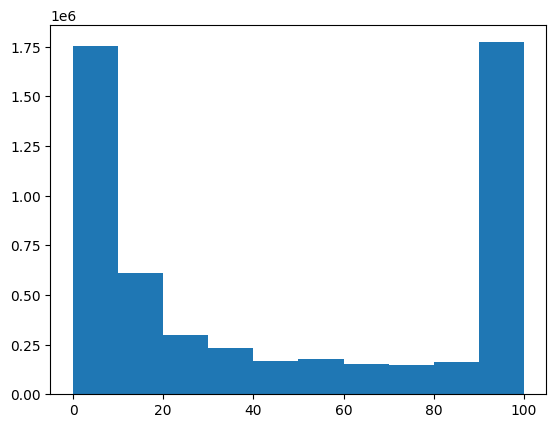

In [183]:
(n, bins, patches) = plt.hist(interactions["watched_pct"], bins=10)

Пользователям обычно либо нравится и они смотрят до конца, либо не нравятся и сразу дропают

In [184]:
# Man: cartoons (4)
user_1_w = [78.0, 9.0, 99.0, 38.0]
# Young man: popular science (3) + adults(1) + horror(1)
user_2_w = [1.0, 9.0, 46.0, 89.0, 3.0]
# Woman: fitness (4)
user_3_w = [96.0, 23.0, 85.0, 67.0]

In [185]:
avatars_interactions["watched_pct"] = user_1_w + user_2_w + user_3_w

In [186]:
avatars_interactions.reset_index()

,index,user_id,item_id,last_watch_dt,total_dur,watched_pct
0,0,-6,8464,2021-07-20,4641,78.0
1,0,-6,11864,2021-06-04,558,9.0
2,0,-6,2378,2021-03-21,18074,99.0
3,0,-6,6138,2021-08-22,8665,38.0
4,1,-66,6096,2021-08-22,3015,1.0
5,1,-66,11222,2021-08-16,101,9.0
6,1,-66,7132,2021-05-10,1235,46.0
7,1,-66,2812,2021-05-18,31,89.0
8,1,-66,14315,2021-05-11,7508,3.0
9,2,-666,2888,2021-07-18,11796,96.0


In [187]:
def convert_to_weight(col):
    if col < 10:
        return 1
    elif col < 30:
        return 2
    elif col < 60:
        return 3
    elif col < 85:
        return 4
    return 5

In [188]:
avatars_interactions[Columns.Weight] = avatars_interactions["watched_pct"].apply(
    lambda x: convert_to_weight(x)
)

In [193]:
avatars_interactions

,user_id,item_id,last_watch_dt,total_dur,watched_pct,weight
0,-6,8464,2021-07-20,4641,78.0,4
0,-6,11864,2021-06-04,558,9.0,1
0,-6,2378,2021-03-21,18074,99.0,5
0,-6,6138,2021-08-22,8665,38.0,3
1,-66,6096,2021-08-22,3015,1.0,1
1,-66,11222,2021-08-16,101,9.0,1
1,-66,7132,2021-05-10,1235,46.0,3
1,-66,2812,2021-05-18,31,89.0,5
1,-66,14315,2021-05-11,7508,3.0,1
2,-666,2888,2021-07-18,11796,96.0,5


Датасет взаимодействий `Interactions` для аватаров готов 

### Avatars Users Feature Generation

In [194]:
headtail(users)

,user_id,age,income,sex,kids_flg
0,973171,age_25_34,income_60_90,М,1
1,962099,age_18_24,income_20_40,М,0
2,1047345,age_45_54,income_40_60,Ж,0
3,721985,age_45_54,income_20_40,Ж,0
4,704055,age_35_44,income_60_90,Ж,0
840192,339025,age_65_inf,income_0_20,Ж,0
840193,983617,age_18_24,income_20_40,Ж,1
840194,251008,Unknown,Unknown,Unknown,0
840195,590706,Unknown,Unknown,Ж,0
840196,166555,age_65_inf,income_20_40,Ж,0


Создаем `users` датасет наших аватаров, исходя из описания

In [195]:
avatars_users = pd.DataFrame(
    data={
        "user_id": [-6, -66, -666],
        "age": ["age_55_64", "age_18_24", "age_35_44"],
        "income": ["income_0_20", "income_150_inf", "income_40_60"],
        "sex": ["М", "М", "Ж"],
        "kids_flg": [0, 1, 0],
    }
)

In [196]:
avatars_users

,user_id,age,income,sex,kids_flg
0,-6,age_55_64,income_0_20,М,0
1,-66,age_18_24,income_150_inf,М,1
2,-666,age_35_44,income_40_60,Ж,0


Все готово к созданию датасета и последующему обучению модели

In [198]:
users = pd.read_csv(DATA_PATH / "users.csv")
items = pd.read_csv(DATA_PATH / "items.csv")
users = pd.concat([users, avatars_users], ignore_index=True)

In [199]:
users.tail()

,user_id,age,income,sex,kids_flg
840195,590706,NaN,NaN,Ж,0
840196,166555,age_65_inf,income_20_40,Ж,0
840197,-6,age_55_64,income_0_20,М,0
840198,-66,age_18_24,income_150_inf,М,1
840199,-666,age_35_44,income_40_60,Ж,0


In [200]:
users_features, items_features = get_features(users, items)

In [201]:
interactions = pd.concat([interactions, avatars_interactions], ignore_index=True)

In [202]:
interactions.tail()

,user_id,item_id,last_watch_dt,total_dur,watched_pct,weight
5476259,-66,14315,2021-07-02,3159,3.0,1
5476260,-666,2888,2021-07-27,205,96.0,5
5476261,-666,8565,2021-05-26,10748,23.0,2
5476262,-666,15465,2021-08-06,5472,85.0,5
5476263,-666,14957,2021-08-05,4158,67.0,4


In [203]:
%%time
dataset = Dataset.construct(
    interactions_df=interactions,
    user_features_df=user_features,
    cat_user_features=["sex", "age", "income", "kids_flg"],
    item_features_df=item_features,
    cat_item_features=[
        "genre",
        "content_type",
        "release_year",
        "for_kids",
        "age_rating",
    ],
)

CPU times: user 18.4 s, sys: 1.72 s, total: 20.1 s
Wall time: 20.4 s


In [204]:
# Optimal hyperparametres due to validation
RANDOM_STATE = 23
NUM_THREADS = 16
# Best hyperparametres
N_FACTORS = 32
N_EPOCHS = 1
LEARNING_RATE = 0.05
USER_ALPHA = 0
ITEM_ALPHA = 0
K_RECOS = 10

In [205]:
model = LightFMWrapperModel(
    LightFM(
        no_components=N_FACTORS,
        loss="warp",
        random_state=RANDOM_STATE,
        learning_rate=LEARNING_RATE,
        user_alpha=USER_ALPHA,
        item_alpha=ITEM_ALPHA,
    ),
    epochs=N_EPOCHS,
    num_threads=NUM_THREADS,
)

In [206]:
model.fit(dataset)

### Avatars Recomendations

In [207]:
model.recommend([-6, -66, -666], dataset=dataset, filter_viewed=True, k=10).merge(
    items[["item_id", "title", "release_year", "genres"]], how="left", on="item_id"
)

,user_id,item_id,score,rank,title,release_year,genres
0,-6,3182,3.847929,1,Ральф против Интернета,2018.0,"мультфильм, приключения, фантастика, семейное,..."
1,-6,9336,3.819947,2,Остров монстров,2018.0,"семейное, мультфильм, фэнтези, приключения"
2,-6,10761,3.770006,3,Моана,2016.0,"мультфильм, фэнтези, мюзиклы"
3,-6,12908,3.681091,4,Человек-паук: Через вселенные,2018.0,"фантастика, мультфильм, приключения"
4,-6,7571,3.679307,5,100% волк,2020.0,"мультфильм, приключения, семейное, фэнтези, ко..."
5,-6,16166,3.664617,6,Зверополис,2016.0,"приключения, мультфильм, детективы, комедии"
6,-6,15334,3.645636,7,"Ронья, дочь разбойника",2014.0,"для детей, аниме, сериалы, приключения, зарубе..."
7,-6,3888,3.644508,8,История игрушек 2,1999.0,"мультфильм, фэнтези, приключения, комедии"
8,-6,15266,3.632289,9,Корпорация монстров,2001.0,"мультфильм, фэнтези, приключения, комедии"
9,-6,9816,3.622309,10,В стране чудес,2019.0,"аниме, фэнтези, приключения"


Что видим:
* Все первые 10 рекомендаций для мужчины это мультфильмы, что наверное логично, так как только они в истории просмотров. Разнообразие модель здесь не внесла
* С парнем поинтереснее. Видим как и жанр документального, так и много других. Здесь разнообразие присутствует, но это может быть фактом того, что модель плохо поняла интересы пользователя - в рекомендациях еще присутствуют айтемы (10440, 15297, 6809, 9996), которые модель рекомендует многим, в том числе и холодным пользователям
* Женщине модель рекомендует вполне оригинальные айтемы, причем в рекомендациях 3 из них относятся к спорту, т.е. здесь модель явно уловила характер пользователя